In [1]:
# Import Required Libraries
import cudaq
import numpy as np
import time
import sys
from cudaq import spin
import matplotlib.pyplot as plt
from typing import List

In [2]:
@cudaq.kernel
def get_initial_state(n_spins: int):
    """Create initial state |1010...>"""
    qubits = cudaq.qvector(n_spins)
    for i in range(0, n_spins, 2):
        x(qubits[i])


In [3]:
@cudaq.kernel
def trotter_step(state: cudaq.State, dt: float, Jx: float, Jy: float, Jz: float,
                 h_x: list[float], h_y: list[float], h_z: list[float], _use_XXYYZZ_gate: bool,
                 coefficients: List[complex], words: List[cudaq.pauli_word]):
    """Perform single Trotter step"""
    qubits = cudaq.qvector(state)
    n_spins = len(qubits)

    # Apply two-qubit interaction terms
    if _use_XXYYZZ_gate:
        for j in range(2):
            for i in range(j % 2, n_spins - 1, 2):
                rx(-np.pi/2,qubits[i])
                rx(np.pi/2,qubits[i+1])
                x.ctrl(qubits[i], qubits[i+1])
                h(qubits[i])
                s(qubits[i])
                rz(-2*Jy*dt,qubits[i+1])
                x.ctrl(qubits[i], qubits[i+1])
                h(qubits[i])
                rx(2*Jx*dt,qubits[i])
                rz(-2*Jz*dt,qubits[i+1])
                x.ctrl(qubits[i], qubits[i+1])
    else:
        for i in range(len(coefficients)):
            exp_pauli(coefficients[i].real * dt, qubits, words[i])

In [4]:
def compute_overlap_probability(initial_state: cudaq.State, evolved_state: cudaq.State):
    """Compute probability of the overlap with the initial state"""
    overlap = initial_state.overlap(evolved_state)
    return np.abs(overlap)**2

In [5]:
def create_hamiltonian_heisenberg(n_spins: int, Jx: float, Jy: float, Jz: float, h_x: list[float], h_y: list[float], h_z: list[float]):
    """Create the Hamiltonian operator"""
    ham = 0

    # Add two-qubit interaction terms for Heisenberg Hamiltonian
    for i in range(0, n_spins - 1):
        ham += Jx * spin.x(i) * spin.x(i + 1)
        ham += Jy * spin.y(i) * spin.y(i + 1)
        ham += Jz * spin.z(i) * spin.z(i + 1)

    return ham

In [6]:
def create_hamiltonian_tfim(n_spins: int, J: float, h_field: float):
    ham = 0

    # Add two-qubit XX interaction terms (with PBC)
    for i in range(n_spins):
        ham += -1 * J * spin.x(i) * spin.x((i + 1) % n_spins)

    # Add single-qubit Z field terms
    for i in range(n_spins):
        ham += -1 * h_field * spin.z(i)

    return ham


In [44]:
def extractCoefficients(hamiltonian: cudaq.SpinOperator):
    result = []
    for term in hamiltonian:
        result.append(term.get_coefficient())
    return result

def extractWords(hamiltonian: cudaq.SpinOperator):
    # Our kernel uses these words to apply exp_pauli to the entire state.
    # we hence ensure that each pauli word covers the entire space.
    n_spins = hamiltonian.qubit_count
    result = []
    for term in hamiltonian:
        result.append(term.get_pauli_word(n_spins))
    return result

In [17]:
import cupy as cp 

def partial_trace_schmidt_cupy(psi: cp.ndarray, keep: List[int], n_qubits: int) -> cp.ndarray:
    psi = psi / cp.linalg.norm(psi)
    traced_out = [i for i in range(n_qubits) if i not in keep]
    dim_keep = 2 ** len(keep)
    dim_traced = 2 ** len(traced_out)

    psi = psi.reshape(dim_keep, dim_traced)
    rho_A = psi @ psi.conj().T
    return rho_A

In [9]:
def entropy(rho):
    eigvals = np.linalg.eigvalsh(rho)
    eigvals = eigvals[eigvals > 0]  
    return -np.sum(eigvals * np.log2(eigvals))


In [76]:
def entropy_simulation (n_spins: int): 
    n = n_spins
    initial_state = cudaq.get_state(get_initial_state, n_spins)
    state = initial_state
    entropy_list = []
    time_list = []
    K = 100 
    dt = n_spins / K  # Time step size
    steps_per_measurement = K // 100
    subsystem = list(range(n_spins // 2))  # Half-chain entropy
    h_field = 2
    
    h_x = np.zeros(n_spins)
    h_y = np.zeros(n_spins)
    h_z = h_field * np.ones(n_spins)
    hamiltonian = create_hamiltonian_tfim(n_spins, J=1.0, h_field=2.0)
    coefficients = extractCoefficients(hamiltonian)
    words = extractWords(hamiltonian)
    Jy = 0 
    Jz = 0
    Jx = 1.0
    _use_XXYYZZ_gate = False
    print(hamiltonian) 
    print(coefficients) 
    
    start_time = time.time()
    for step in range(1, K + 1):
        state = cudaq.get_state(trotter_step, state, dt, Jx, Jy, Jz, h_x, h_y, h_z,
                                _use_XXYYZZ_gate, coefficients, words)
        psi = cp.array(state)
        rho_A = partial_trace_schmidt_cupy(psi, subsystem, n_qubits=n_spins)
        S = entropy(rho_A)
        entropy_list.append(S)
        time_list.append(dt * step)
    
    total_time = time.time() - start_time
    print(f"Simulation done in {total_time:.2f} seconds")
    entropy_np = np.array([x.get() if hasattr(x, 'get') else x for x in entropy_list])
    return entropy_np, subsystem 

In [77]:
n_8, sub_8 = entropy_simulation(8) 
n_16, sub_16 = entropy_simulation(16) 
n_20, sub_20 = entropy_simulation(20) 

/tmp/ipykernel_238153/1119622745.py:4: DeprecationWarning: use `evaluate_coefficient` instead
  result.append(term.get_coefficient())


(0+0i) + (-1+0i) * X0X1 + (-1+0i) * X1X2 + (-1+0i) * X2X3 + (-1+0i) * X3X4 + (-1+0i) * X4X5 + (-1+0i) * X5X6 + (-1+0i) * X6X7 + (-1+0i) * X0X7 + (-2+0i) * Z0 + (-2+0i) * Z1 + (-2+0i) * Z2 + (-2+0i) * Z3 + (-2+0i) * Z4 + (-2+0i) * Z5 + (-2+0i) * Z6 + (-2+0i) * Z7
[0j, (-1+0j), (-1+0j), (-1+0j), (-1+0j), (-1+0j), (-1+0j), (-1+0j), (-1+0j), (-2+0j), (-2+0j), (-2+0j), (-2+0j), (-2+0j), (-2+0j), (-2+0j), (-2+0j)]
Simulation done in 0.16 seconds
(0+0i) + (-1+0i) * X0X1 + (-1+0i) * X1X2 + (-1+0i) * X2X3 + (-1+0i) * X3X4 + (-1+0i) * X4X5 + (-1+0i) * X5X6 + (-1+0i) * X6X7 + (-1+0i) * X7X8 + (-1+0i) * X8X9 + (-1+0i) * X9X10 + (-1+0i) * X10X11 + (-1+0i) * X11X12 + (-1+0i) * X12X13 + (-1+0i) * X13X14 + (-1+0i) * X14X15 + (-1+0i) * X0X15 + (-2+0i) * Z0 + (-2+0i) * Z1 + (-2+0i) * Z2 + (-2+0i) * Z3 + (-2+0i) * Z4 + (-2+0i) * Z5 + (-2+0i) * Z6 + (-2+0i) * Z7 + (-2+0i) * Z8 + (-2+0i) * Z9 + (-2+0i) * Z10 + (-2+0i) * Z11 + (-2+0i) * Z12 + (-2+0i) * Z13 + (-2+0i) * Z14 + (-2+0i) * Z15
[0j, (-1+0j), (-1+0

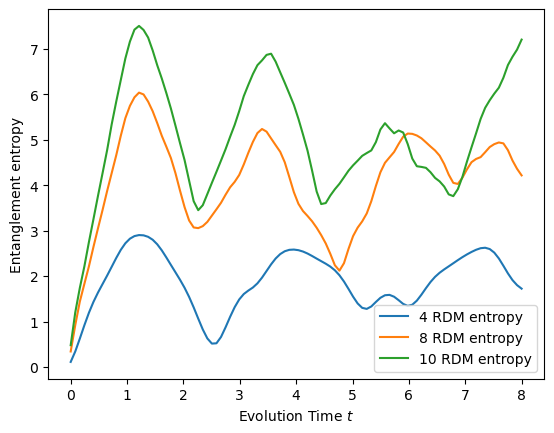

In [78]:
import matplotlib.pyplot as plt
t_list = np.linspace(0, 8, 100)
entropy_np = np.array([x.get() if hasattr(x, 'get') else x for x in entropy_list])

# Plotting the results
fig, ax = plt.subplots()
ax.plot(t_list, n_8, label=f'{len(sub_8)} RDM entropy')
ax.plot(t_list, n_16, label=f'{len(sub_16)} RDM entropy')
ax.plot(t_list, n_20, label=f'{len(sub_20)} RDM entropy')

ax.set_xlabel(rf'Evolution Time $t$')
ax.set_ylabel('Entanglement entropy')
# ax.set_ylabel('Entanglement measures')
ax.legend()


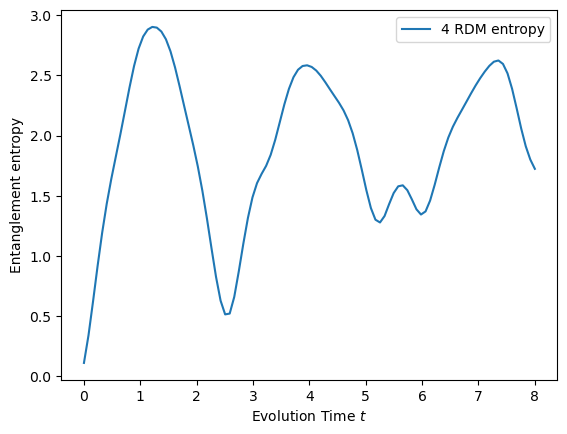

In [79]:
# Plotting the results
fig, ax = plt.subplots()
ax.plot(t_list, n_8, label=f'{len(sub_8)} RDM entropy')

ax.set_xlabel(rf'Evolution Time $t$')
ax.set_ylabel('Entanglement entropy')
# ax.set_ylabel('Entanglement measures')
ax.legend()